# Mask R-CNN with torchvision

In Lab 06, you can use the Mask R-CNN implementation from [the multimodallearning Github repository](https://github.com/multimodallearning/pytorch-mask-rcnn)
or [the Pytorch torchvision R-CNN implementation](https://pytorch.org/vision/stable/models.html#mask-r-cnn).

This is a quickstart on the torchvision version of Mask R-CNN.

For help with fine tuning, see [the PyTorch instance segmentation fine tuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

## Running a pre-trained Mask R-CNN model on test images

First, let's copy some utility code from the torchvision library, load a pre-trained Mask R-CNN model,
and create a dataloader for the COCO validation images.

In [5]:
!pwd

/root/Lab/Lab05


In [3]:
!cp /opt/pytorch/vision/references/detection/utils.py /home/jovyan/work/RTML/Mask\ R-CNN/
!cp /opt/pytorch/vision/references/detection/coco_utils.py /home/jovyan/work/RTML/Mask\ R-CNN/
!cp /opt/pytorch/vision/references/detection/transforms.py /home/jovyan/work/RTML/Mask\ R-CNN/
!cp /opt/pytorch/vision/references/detection/engine.py /home/jovyan/work/RTML/Mask\ R-CNN/
!cp /opt/pytorch/vision/references/detection/coco_eval.py /home/jovyan/work/RTML/Mask\ R-CNN/

cp: cannot stat '/opt/pytorch/vision/references/detection/utils.py': No such file or directory
cp: cannot stat '/opt/pytorch/vision/references/detection/coco_utils.py': No such file or directory
cp: cannot stat '/opt/pytorch/vision/references/detection/transforms.py': No such file or directory
cp: cannot stat '/opt/pytorch/vision/references/detection/engine.py': No such file or directory
cp: cannot stat '/opt/pytorch/vision/references/detection/coco_eval.py': No such file or directory


In [2]:
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py 
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py

--2021-02-25 13:56:59--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 8808 (8.6K) [text/plain]
Saving to: ‘coco_utils.py.1’

coco_utils.py.1     100%[===================>]   8.60K  --.-KB/s    in 0s      

2021-02-25 13:56:59 (41.9 MB/s) - ‘coco_utils.py.1’ saved [8808/8808]

--2021-02-25 13:57:00--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 9757 (9.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   9.53K  --.-KB/s    in 0.004s  

2021-02-25 13:57:01 (2.38 MB/s) - ‘utils.py’ saved [9757/9757]

--2021-02-25 13:57:02--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
Connecting to 192.41.170.23:3128... connected.
Prox

In [1]:

import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

import utils
from coco_utils import get_coco
import transforms

# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).cuda(3)
model.eval()

# Load the COCO 2017 train and val sets. We use the CocoDetection class definition
# from ./coco_utils.py, not the original torchvision.CocoDetection class. Also, we
# use transforms from ./transforms, not torchvision.transforms, because they need
# to transform the bboxes and masks along with the image.

coco_path = "../data/COCO"

transform = transforms.Compose([
    transforms.ToTensor()
])

print('Loading COCO train, val datasets...')
coco_train_dataset = get_coco(coco_path, 'train', transform)
coco_val_dataset = get_coco(coco_path, 'val', transform)

def collate_fn(batch):
    return tuple(zip(*batch))

val_dataloader = torch.utils.data.DataLoader(coco_val_dataset, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

Loading pretrained model...
Loading COCO train, val datasets...
loading annotations into memory...
Done (t=39.48s)
creating index...
index created!
loading annotations into memory...
Done (t=1.41s)
creating index...
index created!


Next, we run the model on a batch from the validation set:

In [2]:
images, targets = next(iter(val_dataloader))
images = [ img.cuda(3) for img in images ]
predictions = model(images)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)


Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([100, 4])
Labels shape: torch.Size([100])
Scores shape: torch.Size([100])
Masks shape: torch.Size([100, 1, 426, 640])


The `predictions` list has one entry for each element of the batch. Each entry has the following keys:
1. `boxes`: A tensor containing $[x1,y1,x2,y2]$ coordinates for the 100 top-scoring bounding boxes.
2. `labels`: A tensor containing integer IDs of the labels corresponding to the 100 top bounding boxes.
3. `scores`: A tensor containing the scores of the top 100 bounding boxes, sorted from highest score to lowest.
4. `masks`: The mask corresponding to the most likely class for each of the top 100 bounding boxes. Each mask is the same size as the input image.

With that information, let's write some code to visualize a result. The `draw_segmentation_map()` function is
adapted from [Debugger Cafe's tutorial on Mask R-CNN](https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn).

In [4]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)


Let's use the code above to visualize the predictions for the first image
in the validation set (index 0), using a threshold of 0.5:

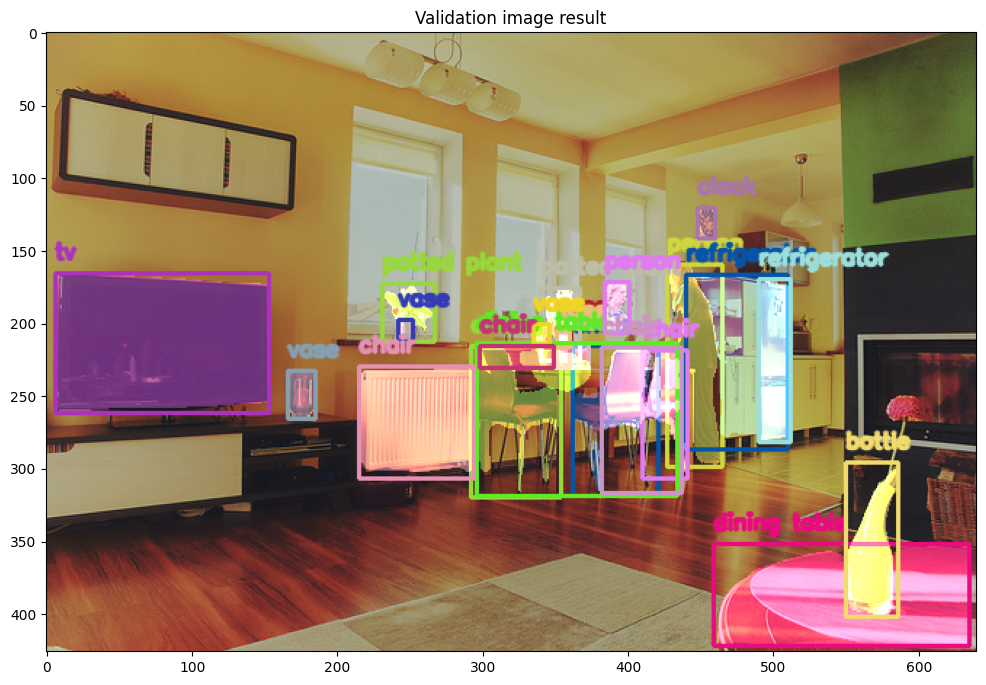

In [5]:
from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

## Evaluate on the COCO validation set

Let's get predictions in a loop for the full COCO 2017 validation set:

In [8]:
from engine import evaluate

results = evaluate(model, val_dataloader, 'cuda:3')


RuntimeError: CUDA error: out of memory

We see mAP of 0.37881 for bounding boxes and 0.34600 for masks.